# 1.Preprocess Data
I use scikit-learn to preprocess data and Glove to initialize word vectors

## 1.1 Load data from text files

In [1]:
import pathlib
with open("D:/CS584/Assignment_4/a4-data/q1/28054-0.txt",encoding="UTF-8") as f:
    Fyodor_Dostoyevsky = f.read();
with open("D:/CS584/Assignment_4/a4-data/q1/pg1661.txt",encoding="UTF-8") as f:
    Arthur_Conan_Doyle = f.read();
with open("D:/CS584/Assignment_4/a4-data/q1/pg31100.txt",encoding="UTF-8") as f:
    Jane_Austen = f.read();

## 1.2 Remove Punctuation, Url, chapter title and title

In [2]:
import re, string
from array import *

def remove_url(text):
    return re.sub(r"http\S+", "", text)

def remove_text_other_than_word_and_space(text):
    return re.sub('[^a-zA-Z\s]',"", text)

def remove_n(text):
    return re.sub('\n','',text)

def preprocess(text):
    text = remove_url(text)
    text = remove_text_other_than_word_and_space(text)
    text = remove_n(text)
    return text

def split_base_on_chapter(text):
    return re.split('\n?chapter.+\n|\n?adventure.+\n',text)

def merge_into_one_line(text, paragraphs):
    text = text.lower()
    lines = split_base_on_chapter(text)
    temp = ""
    for line in lines:
        if len(line.strip(" ")) == 0:
            continue
        line = preprocess(line)
        if len(line)>0:
            temp = temp + " " + line
    types.append(type)
    paragraphs.append(temp)
    return paragraphs


    
total_paragraph = 0
paragraphs = []
types = []

paragraphs = merge_into_one_line(Fyodor_Dostoyevsky,paragraphs)
paragraphs = merge_into_one_line(Arthur_Conan_Doyle,paragraphs)
paragraphs = merge_into_one_line(Jane_Austen,paragraphs)

## 1.3 Tokenize the data and split into window sized sentence

In [3]:
import numpy

def split_base_on_window_size(tokenized_sentence, window_size):
    type = 0
    types = []
    paragraph_split = []
    for line in tokenized_sentence:
        count = 0
        words = []
        for word in line:
            words.append(word)
            count += 1
            if count == window_size:
                paragraph_split.append(words)
                temp = numpy.zeros(shape=(3,))
                temp[type] = 1
                types.append(temp)
                count = 0
                words = []
        type += 1
    return paragraph_split, types

from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(paragraphs)
tokenized_sentence = tokenizer.texts_to_sequences(paragraphs)

window_size = 20

tokenized_sentence, types = split_base_on_window_size(tokenized_sentence, window_size)
total_paragraph = len(tokenized_sentence)

## 1.4 Determine range of training and test


In [4]:
import numpy
rand_indices = numpy.random.permutation(total_paragraph)
train_indices = rand_indices[0:int(total_paragraph*0.8)]
test_indices = rand_indices[int(total_paragraph*0.8):total_paragraph]

tokenized_sentence = numpy.array(tokenized_sentence)
types = numpy.array(types)

train_x = tokenized_sentence[train_indices,:]
train_y = types[train_indices]

test_x = tokenized_sentence[test_indices,:]
text_y = types[test_indices]

## 1.5 Load GloVe vectors

In [5]:
embeddings_dict = {}
with open("D:/CS584/glove.6B/glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = numpy.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

num_tokens = len(tokenizer.index_word) + 2

embedding_params = numpy.ones(shape=(num_tokens, 50),dtype="float32")
for i in range(len(tokenizer.index_word)):
    word = tokenizer.index_word[i+1]
    if word in embeddings_dict:
        embedding_params[i] = embeddings_dict[word]

# 2. Define LSTM and CNN

# 2.1 LSTM model

In [6]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, Embedding, LSTM, Softmax, Dense, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.initializers import Constant

def get_lstm_model(embedding_params):
    model = Sequential()
    model.add(Embedding(input_dim=num_tokens, output_dim=50,
                        embeddings_initializer=Constant(embedding_params)))
    model.add(Bidirectional(LSTM(128, return_sequences=True), merge_mode='ave'))
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(3, activation='relu'))
    model.add(Softmax())
    return model

batch_size = 30

lstm_model = get_lstm_model(embedding_params)
lstm_model.build((batch_size, window_size))
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          4493950   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         183296    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 128)         512       
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
_________________________________________________________________
softmax (Softmax)            (None, 3)                 0         
Total params: 4,678,145
Trainable params: 4,677,889
Non-trainable params: 256
____________________________________________

## 2.2 CNN model

In [7]:
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalMaxPooling1D


def get_cnn_model(embedding_params):
    model = Sequential()
    model.add(Embedding(input_dim=num_tokens, output_dim=50,
                        embeddings_initializer=Constant(embedding_params)))
    model.add(Conv1D(filters=64, kernel_size=3, activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool1D(3))
    model.add(Conv1D(filters=32, kernel_size=3, activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling1D())
    model.add(Dense(3, activation='relu'))
    model.add(Softmax())
    return model

cnn_model = get_cnn_model(embedding_params)
cnn_model.build((batch_size, window_size))
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          4493950   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          9664      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 64)          256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          6176      
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 32)          128       
_________________________________________________________________
global_max_pooling1d (Global (None, 32)               

# 3. Train and test model

## 3.1 Train LSTM

In [8]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=1e-3)

lstm_model.compile(optimizer=opt,
                  loss='categorical_crossentropy')
lstm_model.fit(train_x,
               train_y,
               epochs=20,
               shuffle=True,
               verbose=2)
lstm_model.save('lstm_mode.h5')

Train on 45272 samples
Epoch 1/20
45272/45272 - 57s - loss: 0.5318
Epoch 2/20
45272/45272 - 52s - loss: 0.2376
Epoch 3/20
45272/45272 - 52s - loss: 0.1015
Epoch 4/20
45272/45272 - 52s - loss: 0.0531
Epoch 5/20
45272/45272 - 52s - loss: 0.0378
Epoch 6/20
45272/45272 - 52s - loss: 0.0284
Epoch 7/20
45272/45272 - 52s - loss: 0.0249
Epoch 8/20
45272/45272 - 52s - loss: 0.0203
Epoch 9/20
45272/45272 - 52s - loss: 0.0197
Epoch 10/20
45272/45272 - 52s - loss: 0.0167
Epoch 11/20
45272/45272 - 52s - loss: 0.0166
Epoch 12/20
45272/45272 - 52s - loss: 0.0150
Epoch 13/20
45272/45272 - 52s - loss: 0.0138
Epoch 14/20
45272/45272 - 53s - loss: 0.0114
Epoch 15/20
45272/45272 - 52s - loss: 0.0110
Epoch 16/20
45272/45272 - 52s - loss: 0.0098
Epoch 17/20
45272/45272 - 52s - loss: 0.0100
Epoch 18/20
45272/45272 - 52s - loss: 0.0105
Epoch 19/20
45272/45272 - 52s - loss: 0.0103
Epoch 20/20
45272/45272 - 52s - loss: 0.0099


## 3.2 Train CNN

In [9]:
opt = Adam(learning_rate=1e-3)
cnn_model.compile(optimizer=opt,
                  loss='categorical_crossentropy')
cnn_model.fit(train_x,
               train_y,
               epochs=20,
               shuffle=True,
               verbose=2)
cnn_model.save('cnn_mode.h5')

Train on 45272 samples
Epoch 1/20
45272/45272 - 53s - loss: 0.7446
Epoch 2/20
45272/45272 - 52s - loss: 0.4014
Epoch 3/20
45272/45272 - 52s - loss: 0.2400
Epoch 4/20
45272/45272 - 52s - loss: 0.1233
Epoch 5/20
45272/45272 - 52s - loss: 0.0593
Epoch 6/20
45272/45272 - 52s - loss: 0.0378
Epoch 7/20
45272/45272 - 52s - loss: 0.0297
Epoch 8/20
45272/45272 - 52s - loss: 0.0251
Epoch 9/20
45272/45272 - 52s - loss: 0.0175
Epoch 10/20
45272/45272 - 52s - loss: 0.0189
Epoch 11/20
45272/45272 - 52s - loss: 0.0183
Epoch 12/20
45272/45272 - 52s - loss: 0.0190
Epoch 13/20
45272/45272 - 52s - loss: 0.0134
Epoch 14/20
45272/45272 - 52s - loss: 0.0123
Epoch 15/20
45272/45272 - 52s - loss: 0.0119
Epoch 16/20
45272/45272 - 52s - loss: 0.0094
Epoch 17/20
45272/45272 - 52s - loss: 0.0103
Epoch 18/20
45272/45272 - 52s - loss: 0.0089
Epoch 19/20
45272/45272 - 52s - loss: 0.0083
Epoch 20/20
45272/45272 - 52s - loss: 0.0118


## 3.3 Test LSTM and CNN

In [10]:
from tensorflow.keras.models import load_model
lstm_model = load_model('lstm_mode.h5')
cnn_model = load_model('cnn_mode.h5')

In [11]:
from sklearn.metrics import recall_score, f1_score, precision_score
def predict(x):
    result = []
    for xi in x:
        i = numpy.argmax(xi)
        temp = numpy.zeros(shape=(3,))
        temp[i] = 1
        result.append(temp)
    return numpy.array(result)

pred_y = lstm_model.predict(test_x)
pred_y = predict(pred_y)


lstm_f1 = f1_score(text_y, pred_y, average='macro')
lstm_re = recall_score(text_y, pred_y, average='macro')
lstm_pr = precision_score(text_y, pred_y, average='macro')

In [12]:
pred_y = cnn_model.predict(test_x)
pred_y = predict(pred_y)

cnn_f1 = f1_score(text_y, pred_y, average='macro')
cnn_re = recall_score(text_y, pred_y, average='macro')
cnn_pr = precision_score(text_y, pred_y, average='macro')

In [13]:
print("lstm: F1="+str(lstm_f1)+" recall="+str(lstm_re)+" precision="+str(lstm_pr))
print("cnn: F1="+str(cnn_f1)+" recall="+str(cnn_re)+" precision="+str(cnn_pr))

lstm: F1=0.7703505015055739 recall=0.7592023246302918 precision=0.7924121297852967
cnn: F1=0.7448540452197842 recall=0.7283758593971884 precision=0.7663272937774174


# 4. Compare between LR, MLP, CNN, LSTM

## 4.1 split data base on window size

In [14]:
def split_document_base_on_window_size(paragraphs, window_size):
    type = 0
    types = []
    mlp_types = []
    paragraph_split = []
    for document in paragraphs:
        words = document.split()
        count = 0
        temp_words = []
        for word in words:
            temp_words.append(word)
            count += 1
            if count == window_size:
                paragraph_split.append(temp_words)
                temp = numpy.zeros(shape=(3,))
                temp[type] = 1
                types.append(type)
                mlp_types.append(temp)
                count = 0
                temp_words = []
        type += 1
    return paragraph_split, types, mlp_types

def listToString(s):  
    str1 = " "  
    return (str1.join(s)) 

sentences, tf_types, mlp_types = split_document_base_on_window_size(paragraphs, window_size)
tf_types = numpy.array(tf_types)
mlp_types = numpy.array(mlp_types)
for i in range(len(sentences)):
    sentences[i] = listToString(sentences[i])

## 4.2 get TF-IDF Score and split into train and test

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
tf_idf = vectorizer.fit_transform(sentences)

tf_train_x = tf_idf[train_indices]
tf_test_x = tf_idf[test_indices]

tf_train_y = tf_types[train_indices]
tf_test_y = tf_types[test_indices]
ml_train_y = mlp_types[train_indices]
ml_test_y = mlp_types[test_indices]

## 4.3 Train and get f1, recall, precision score of LR

In [16]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(tf_train_x, tf_train_y)

C:\Users\maik1\Anaconda3\envs\CS583\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [17]:
LR_pred = clf.predict(tf_test_x)

LR_f1 = f1_score(tf_test_y, LR_pred, average="macro")
LR_pr = precision_score(tf_test_y, LR_pred, average="macro")
LR_re = recall_score(tf_test_y, LR_pred, average="macro")

## 4.4 Train and get f1, recall, precision score of MLP

In [18]:
tf_train_x = tf_train_x.toarray()
MLP_model = Sequential()
MLP_model.add(Dense(128, activation = 'relu', input_shape = (tf_train_x.shape[1],)))
MLP_model.add(Dense(3, activation = 'softmax'))

MLP_model.compile(optimizer=opt, loss='categorical_crossentropy')
MLP_model.fit(tf_train_x, ml_train_y, epochs=10, batch_size=64, verbose=2)

Train on 45272 samples
Epoch 1/10
45272/45272 - 36s - loss: 0.3514
Epoch 2/10
45272/45272 - 25s - loss: 0.0841
Epoch 3/10
45272/45272 - 25s - loss: 0.0294
Epoch 4/10
45272/45272 - 17s - loss: 0.0128
Epoch 5/10
45272/45272 - 18s - loss: 0.0072
Epoch 6/10
45272/45272 - 17s - loss: 0.0048
Epoch 7/10
45272/45272 - 49s - loss: 0.0038
Epoch 8/10
45272/45272 - 42s - loss: 0.0030
Epoch 9/10
45272/45272 - 28s - loss: 0.0024
Epoch 10/10
45272/45272 - 31s - loss: 0.0021


In [19]:
tf_test_x = tf_test_x.toarray()
pred_y = MLP_model.predict(tf_test_x)
pred_y = predict(pred_y)

MLP_f1 = f1_score(ml_test_y, pred_y, average='macro')
MLP_re = recall_score(ml_test_y, pred_y, average='macro')
MLP_pr = precision_score(ml_test_y, pred_y, average='macro')

## 4.5 Table

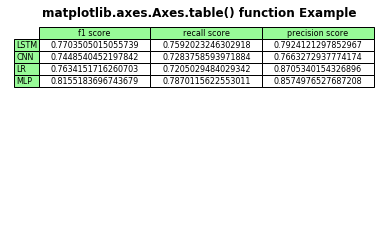

In [20]:
import matplotlib.pyplot as plt 
  
val1 = ["f1 score", "recall score", "precision score"] 
val2 = ["LSTM", "CNN", "LR", "MLP"] 
val3 = [[lstm_f1,lstm_re,lstm_pr],
        [cnn_f1,cnn_re,cnn_pr],
        [LR_f1,LR_re,LR_pr],
        [MLP_f1,MLP_re,MLP_pr]] 
  
fig, ax = plt.subplots() 
ax.set_axis_off() 
table = ax.table( 
    cellText = val3,  
    rowLabels = val2,  
    colLabels = val1, 
    rowColours =["palegreen"] * 10,  
    colColours =["palegreen"] * 10, 
    cellLoc ='center',  
    loc ='upper left')         
  
ax.set_title('matplotlib.axes.Axes.table() function Example', 
             fontweight ="bold") 
  
plt.show() 